In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "2" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "2" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "2" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "2" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "2" # export NUMEXPR_NUM_THREADS=6

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp#, odeint
from scipy.stats import norm

import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [3]:
SAMPLING_SEED = 234
RANDOM_SEED = 234
np.random.seed(RANDOM_SEED)

In [4]:
def predator_prey(t, y, a, b, c, d):
    return np.array([a*y[0] - b*y[0]*y[1], c*y[0]*y[1] - d*y[1]])

In [5]:
P_0 = 10
Q_0 = 5
a = 3.0
b = 0.7
c = 0.2
d = 1.0

true_parameters = np.array([P_0, Q_0, a, b, c, d])
t_span = [0,12]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

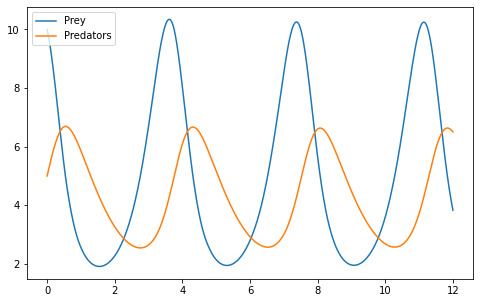

In [6]:
y = solve_ivp(predator_prey, t_span, np.array([P_0, Q_0]), args=(a,b,c,d), t_eval=t_eval)

plt.figure(figsize=(8,5))
plt.plot(y.t, y.y.T, label=['Prey', 'Predators'])
plt.legend(loc=2)
plt.show()

In [7]:
sigma = 1.0
t_end = [4, 8, 12]
n_data = [9, 17, 25]
#t_end = [4, 8, 12]
#n_data = [9, 17, 25]

datapoints = []
data_crisp = []
for t, n in zip(t_end, n_data):
    x = np.linspace(0, t, n)
    datapoints.append(x)
    
    y = solve_ivp(predator_prey, [0, t], np.array([P_0, Q_0]), args=(a,b,c,d), t_eval=x)
    data_crisp.append(y.y)
    #data.append(y.y + np.random.normal(scale=sigma, size=y.y.shape))

data = []
noise = np.random.normal(scale=sigma, size=data_crisp[-1].shape)
for i, d in enumerate(data_crisp):
    d_noise = d + noise[:d.shape[0], :d.shape[1]]
    d_noise[d_noise < 0] = 0
    data.append(d_noise)

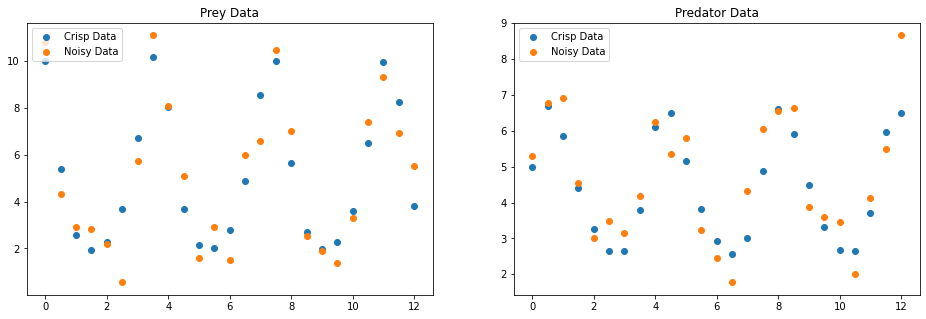

In [8]:
fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

axes[0].scatter(datapoints[-1], data_crisp[-1][0,:], label='Crisp Data')
axes[0].scatter(datapoints[-1], data[-1][0,:], label='Noisy Data')
axes[0].legend(loc=2); axes[0].set_title('Prey Data')

axes[1].scatter(datapoints[-1], data_crisp[-1][1,:], label='Crisp Data')
axes[1].scatter(datapoints[-1], data[-1][1,:], label='Noisy Data')
axes[1].legend(loc=2); axes[1].set_title('Predator Data')

plt.show()

In [9]:
class PredatorPreyModel:
    def __init__(self, datapoints):
        self.datapoints = datapoints
        self.n_data = self.datapoints.shape[0]
        self.t_span = [0, self.datapoints[-1]]

    def __call__(self, parameters):
        #print(parameters)
        P_0, Q_0, a, b, c, d = parameters
        y = solve_ivp(predator_prey, self.t_span, np.array([P_0, Q_0]), args=(a,b,c,d), t_eval=self.datapoints) 
        if y.success:
            return y.y
        else:
            return np.zeros((2, self.n_data))

In [10]:
my_models = []
for i, d in enumerate(datapoints):
    my_models.append(PredatorPreyModel(d))
    print(np.all(my_models[i](true_parameters) == data_crisp[i]))

True
True
True


In [11]:
import time

In [12]:
%%timeit
my_models[0](true_parameters)

1.01 ms ± 4.67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%%timeit
my_models[1](true_parameters)

1.72 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%%timeit
my_models[2](true_parameters)

2.63 ms ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
class LogLike(tt.Op):
    
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, data, sigma, pymc3_model):

        # add inputs as class attributes
        self.my_model = my_model
        self.data = data
        
        self.sigma = sigma
        
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        theta = inputs[0]
        
        model_output = self.my_model(theta)
        
        self.pymc3_model.Q.set_value(model_output[1,:].mean())
        logl = -0.5 * np.sum((model_output - self.data)**2)/self.sigma**2
        
        outputs[0][0] = np.array(logl) # output the log-likelihood

In [16]:
# Set up models in pymc3 for each level - excluding finest model level
logl = []
coarse_models = []

for i, m in enumerate(my_models[:-1]):
    with pm.Model() as model:
        
        # Set the quantity of interest.
        Q = pm.Data("Q", np.float64(0))
        
        P_0 = pm.Normal('P_0', mu=10.0, sigma=1.0)
        Q_0 = pm.Normal('Q_0', mu=5.0, sigma=1.0)
        a = pm.Normal('a', mu=2.5, sigma=0.5)
        b = pm.InverseGamma('b', alpha=1.0, beta=0.5)
        c = pm.InverseGamma('c', alpha=1.0, beta=0.5)
        d = pm.Normal('d', mu=1.2, sigma=0.3)
        theta = tt.as_tensor_variable([P_0, Q_0, a, b, c, d])
        
        #theta = pm.MvNormal('theta', mu=mu_prior, cov=cov_prior, shape=n_dim)
        
        logl.append(LogLike(m, data[i], sigma, model))
        
        # Use the Potential class to evaluate likelihood (DensityDist appears to be broken)
        pm.Potential('likelihood', logl[i](theta))
        
        coarse_models.append(model)

In [17]:
ndraws = 10000
ntune = 1000
nchains= 4
nsub = 10

with pm.Model() as model:
    # A variable Q has to be defined if you want to use the variance reduction feature
    # Q can be of any dimension - here it a scalar
    Q = pm.Data("Q", np.float64(0))

    P_0 = pm.Normal('P_0', mu=10.0, sigma=1.0)
    Q_0 = pm.Normal('Q_0', mu=5.0, sigma=1.0)
    a = pm.Normal('a', mu=2.5, sigma=0.5)
    b = pm.InverseGamma('b', alpha=1.0, beta=0.5)
    c = pm.InverseGamma('c', alpha=1.0, beta=0.5)
    d = pm.Normal('d', mu=1.2, sigma=0.3)
    theta = tt.as_tensor_variable([P_0, Q_0, a, b, c, d])
    
    #theta = pm.MvNormal('theta', mu=mu_prior, cov=cov_prior, shape=n_dim)

    # Here we instatiate a Likelihood object using the class defined above
    # and we add to the mout list. We pass the fine data x and y
    # and the fine pymc3 model model. This creates a fine likelihood.
    logl.append(LogLike(my_models[-1], data[-1], sigma, model))

    # This uses the likelihood object to define the likelihood of the model, given theta
    pm.Potential("likelihood", logl[-1](theta))
    
    MAP = pm.find_MAP(method='Powell')
    print(MAP)

    # MLDA with variance reduction
    step_with = pm.MLDA(coarse_models=coarse_models, subsampling_rates=nsub, variance_reduction=True)

    # MLDA without variance reduction
    step_without = pm.MLDA(coarse_models=coarse_models, subsampling_rates=nsub, variance_reduction=False, store_Q_fine=True)

    # sample
    trace1 = pm.sample(draws=ndraws, step=step_with, chains=nchains, tune=ntune, discard_tuned_samples=True, start=MAP, random_seed=SAMPLING_SEED)
    trace2 = pm.sample(draws=ndraws, step=step_without, chains=nchains, tune=ntune, discard_tuned_samples=True, start=MAP, random_seed=SAMPLING_SEED)


{'P_0': array(9.62936153), 'Q_0': array(5.2426856), 'a': array(2.049457), 'b_log__': array(-0.72750498), 'c_log__': array(-1.25195215), 'd': array(1.44767147), 'b': array(0.48311286), 'c': array(0.28594604)}


/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:386: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:386: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
/tmp/ipykernel_62403/2777412454.py:39: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace1 = pm.sample(draws=ndraws, step=step_with, chains=nchains, tune=ntune, discard_tuned_samples=True, start=MAP, random_seed=SAMPLING_SEED)
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=

/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1392: FutureWarning: Trace-continuation is not supported in v4.
  warnings.warn("Trace-continuation is not supported in v4.", FutureWarning)
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1392: FutureWarning: Trace-continuation is not supported in v4.
  warnings.warn("Trace-continuation is not supported in v4.", FutureWarning)
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1392: FutureWarning: Trace-continuation is not supported in v4.
  warnings.warn("Trace-continuation is not supported in v4.", FutureWarning)
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1392: FutureWarning: Trace-continuation is not supported in v4.
  warnings.warn("Trace-continuation is not supported in v4.", FutureWarning)
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 4364 seconds.
The number of effective samples is smaller than 

/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1392: FutureWarning: Trace-continuation is not supported in v4.
  warnings.warn("Trace-continuation is not supported in v4.", FutureWarning)
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1392: FutureWarning: Trace-continuation is not supported in v4.
  warnings.warn("Trace-continuation is not supported in v4.", FutureWarning)
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1392: FutureWarning: Trace-continuation is not supported in v4.
  warnings.warn("Trace-continuation is not supported in v4.", FutureWarning)
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1392: FutureWarning: Trace-continuation is not supported in v4.
  warnings.warn("Trace-continuation is not supported in v4.", FutureWarning)
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 5397 seconds.
The number of effective samples is smaller than 

In [18]:
pm.stats.summary(trace1)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P_0,9.941,0.418,9.162,10.722,0.007,0.005,3277.0,3599.0,1.0
Q_0,5.036,0.331,4.384,5.626,0.005,0.004,3633.0,4627.0,1.0
a,2.757,0.285,2.247,3.294,0.006,0.004,2656.0,3505.0,1.0
d,1.102,0.113,0.889,1.311,0.002,0.002,2663.0,3363.0,1.0
b,0.617,0.062,0.508,0.737,0.001,0.001,2816.0,3077.0,1.0
c,0.223,0.023,0.180,0.266,0.000,0.000,2788.0,3534.0,1.0


In [19]:
pm.stats.summary(trace2)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P_0,9.933,0.417,9.179,10.737,0.007,0.005,3240.0,3739.0,1.0
Q_0,5.035,0.330,4.427,5.673,0.005,0.004,3607.0,4068.0,1.0
a,2.770,0.289,2.227,3.317,0.005,0.004,2883.0,3180.0,1.0
d,1.097,0.115,0.865,1.299,0.002,0.002,2943.0,3312.0,1.0
b,0.620,0.064,0.502,0.743,0.001,0.001,2927.0,3181.0,1.0
c,0.222,0.023,0.177,0.264,0.000,0.000,2918.0,3193.0,1.0


/tmp/ipykernel_62403/3729734971.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.plots.traceplot(trace1)
Got error No model on context stack. trying to find log_likelihood in translation.
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


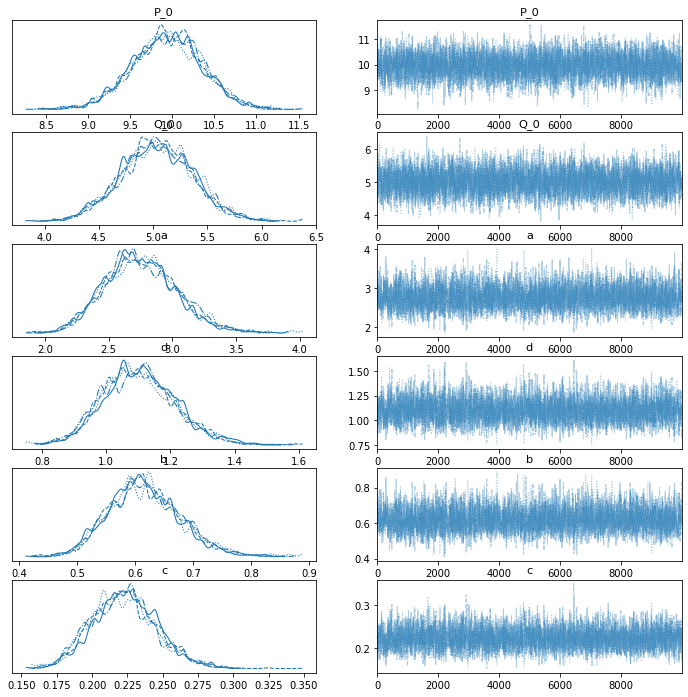

In [20]:
pm.plots.traceplot(trace1)
plt.show()

/tmp/ipykernel_62403/471008358.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.plots.traceplot(trace2)
Got error No model on context stack. trying to find log_likelihood in translation.
/home/mikkel/venv/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


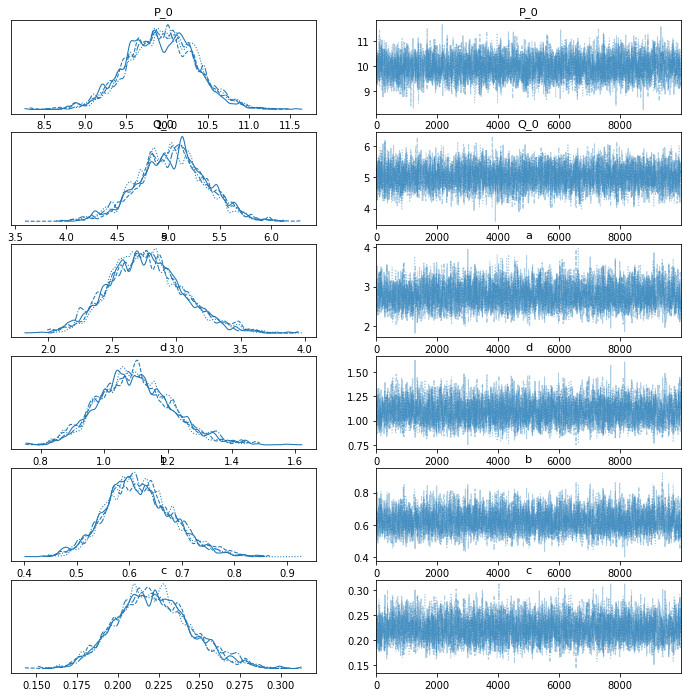

In [21]:
pm.plots.traceplot(trace2)
plt.show()

In [22]:
# MLDA without VR
Q_2 = np.array(trace2.get_sampler_stats("Q_2").reshape((1, nchains * ndraws)).tolist())
#Q_2 = trace2.get_sampler_stats("Q_2").reshape((1, nchains * ndraws))

# MLDA with VR
Q_0 = np.concatenate(trace1.get_sampler_stats("Q_0")).reshape((1, nchains * ndraws * nsub * nsub))
Q_1_0 = np.concatenate(trace1.get_sampler_stats("Q_1_0")).reshape((1, nchains * ndraws * nsub))
Q_2_1 = np.concatenate(trace1.get_sampler_stats("Q_2_1")).reshape((1, nchains * ndraws))

# Estimates
Q_mean_standard = Q_2.mean()
Q_mean_vr = Q_0.mean() + Q_1_0.mean() + Q_2_1.mean()

print(f"Q_0 mean = {Q_0.mean()}")
print(f"Q_1_0 mean = {Q_1_0.mean()}")
print(f"Q_2_1 mean = {Q_2_1.mean()}")
print(f"Q_2 mean = {Q_2.mean()}")
print(f"\nVR method:    Mean: {Q_mean_vr}")
print(f"Standard method:    Mean: {Q_mean_standard}")

Q_0 mean = 4.644216974368933
Q_1_0 mean = -0.06284469527344581
Q_2_1 mean = 0.054609725105805876
Q_2 mean = 4.637232566937278

VR method:    Mean: 4.635982004201293
Standard method:    Mean: 4.637232566937278


In [23]:
step = 5000

Q_2_SE = np.zeros(int(nchains * ndraws / step))
Q_0_SE = np.zeros(int(nchains * ndraws / step))
Q_1_0_SE = np.zeros(int(nchains * ndraws / step))
Q_2_1_SE = np.zeros(int(nchains * ndraws / step))
E_standard_SE = np.zeros(int(nchains * ndraws / step))
E_VR_SE = np.zeros(int(nchains * ndraws / step))
k = 0

for i in np.arange(step, nchains * ndraws + 1, step):
    Q_2_SE[k] = Q_2[0, 0:i].var() / az.ess(np.array(Q_2[0, 0:i], np.float64))
    
    Q_0_SE[k] = Q_0[0, 0 : i * nsub * nsub].var() / az.ess(
        np.array(Q_0[0, 0 : i * nsub * nsub], np.float64)
    )
    Q_1_0_SE[k] = Q_1_0[0, 0 : i * nsub].var() / az.ess(
        np.array(Q_1_0[0, 0 : i * nsub], np.float64)
    )
    Q_2_1_SE[k] = Q_2_1[0, 0 : i].var() / az.ess(
        np.array(Q_2_1[0, 0 : i], np.float64)
    )
    
    E_standard_SE[k] = np.sqrt(Q_2_SE[k])
    E_VR_SE[k] = np.sqrt(Q_0_SE[k] + Q_1_0_SE[k] + Q_2_1_SE[k])
    k += 1

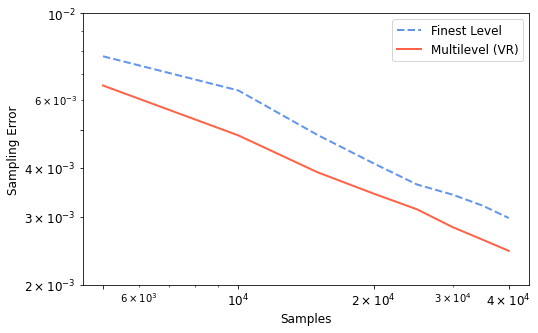

In [24]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(np.arange(step, nchains * ndraws + 1, step), E_standard_SE, color='cornflowerblue', linewidth=2, linestyle='dashed')
ax.plot(np.arange(step, nchains * ndraws + 1, step), E_VR_SE, color='tomato', linewidth=2)
#ax.plot(np.arange(step, nchains * ndraws + 1, step), np.sqrt(Q_0_SE), color='goldenrod', linewidth=2)
ax.set_xscale('log')
#ax.set_xticks([2000, 5000, 10000, 20000, 50000])
ax.set_xticks([5000, 10000, 20000, 40000])
#ax.get_xaxis().set_major_formatter(ScalarFormatter())

ax.set_yscale('log')
ax.set_yticks([2e-3, 3e-3, 4e-3, 5e-3, 1e-2])
#ax.get_yaxis().set_major_formatter(ScalarFormatter())
#ax.get_yaxis().set_minor_formatter(LogFormatterSciNotation())

plt.xlabel("Samples", fontsize=12)
plt.ylabel("Sampling Error", fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(["Finest Level", "Multilevel (VR)"], fontsize=12)
#plt.savefig('se.pdf', bbox_inches='tight')
plt.show()

In [25]:
all_parameters = []
for par in ['P_0', 'Q_0', 'a', 'b', 'c', 'd']:
    all_parameters.append(trace1.get_values(par))
all_parameters = np.array(all_parameters)

In [26]:
n_samples = 1000
samples = np.random.choice(all_parameters.shape[1], size=n_samples, replace=False)

x_plotting = np.linspace(0,12,1000)
model_plotting = PredatorPreyModel(x_plotting)

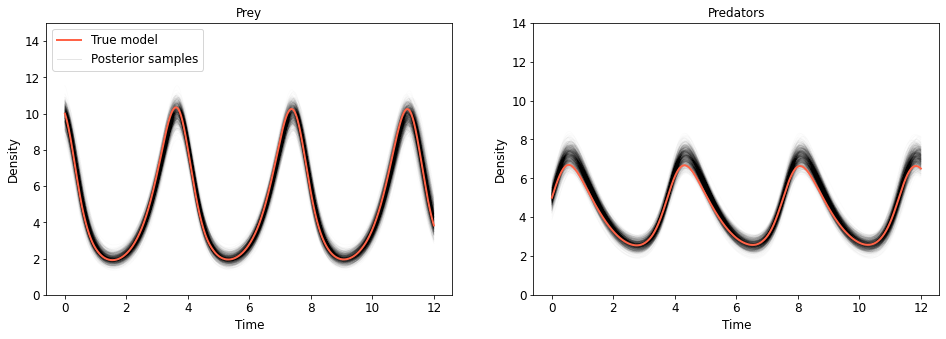

In [27]:
fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

for s in samples:
    y_plotting = model_plotting(all_parameters[:,s])
    axes[0].plot(x_plotting, y_plotting[0,:], color='k', linewidth=1, alpha=0.01)
    axes[1].plot(x_plotting, y_plotting[1,:], color='k', linewidth=1, alpha=0.01)

y_plotting = model_plotting(true_parameters)

axes[0].set_title('Prey', fontsize=12)
axes[0].plot(x_plotting, y_plotting[0,:], color='tomato', linewidth=2, label='True model')
axes[0].plot([], [], color='k', linewidth=1, alpha=0.1, label='Posterior samples')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylim(0, 15); axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend(loc=2, fontsize=12)

axes[1].set_title('Predators', fontsize=12)
axes[1].plot(x_plotting, y_plotting[1,:], color='tomato', linewidth=2)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylim(0, 14); axes[1].set_ylabel('Density', fontsize=12)

plt.savefig('pp_samples.pdf', bbox_inches='tight')
#plt.show()

In [28]:
import pickle

with open('trace_VR.pickle', 'wb') as f:
    pickle.dump(trace1, f)

with open('trace_noVR.pickle', 'wb') as f:
    pickle.dump(trace2, f)